In [23]:
import torch
from torch.autograd import Variable
# from torchvision.models import resnet18, vgg16, resnet34, resnet50
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import os
import torchvision
import scipy.ndimage as nd
import torch.nn as nn
import torchvision.models as models
import torch.utils.model_zoo as model_zoo

%matplotlib inline

In [24]:
transforms = transforms.Compose([
#         transforms.CenterCrop(299),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
dset = datasets.ImageFolder(os.path.join('./data/'), transforms)
dset_loader = torch.utils.data.DataLoader(dset, batch_size=1)
inputs, classes = next(iter(dset_loader))
input_np = inputs.numpy()
# print(input_np.shape)

In [25]:
import PIL.Image
from cStringIO import StringIO
from IPython.display import clear_output, Image, display
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


In [41]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class MyResnet(models.resnet.ResNet):
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
        return x
    
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = MyResnet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

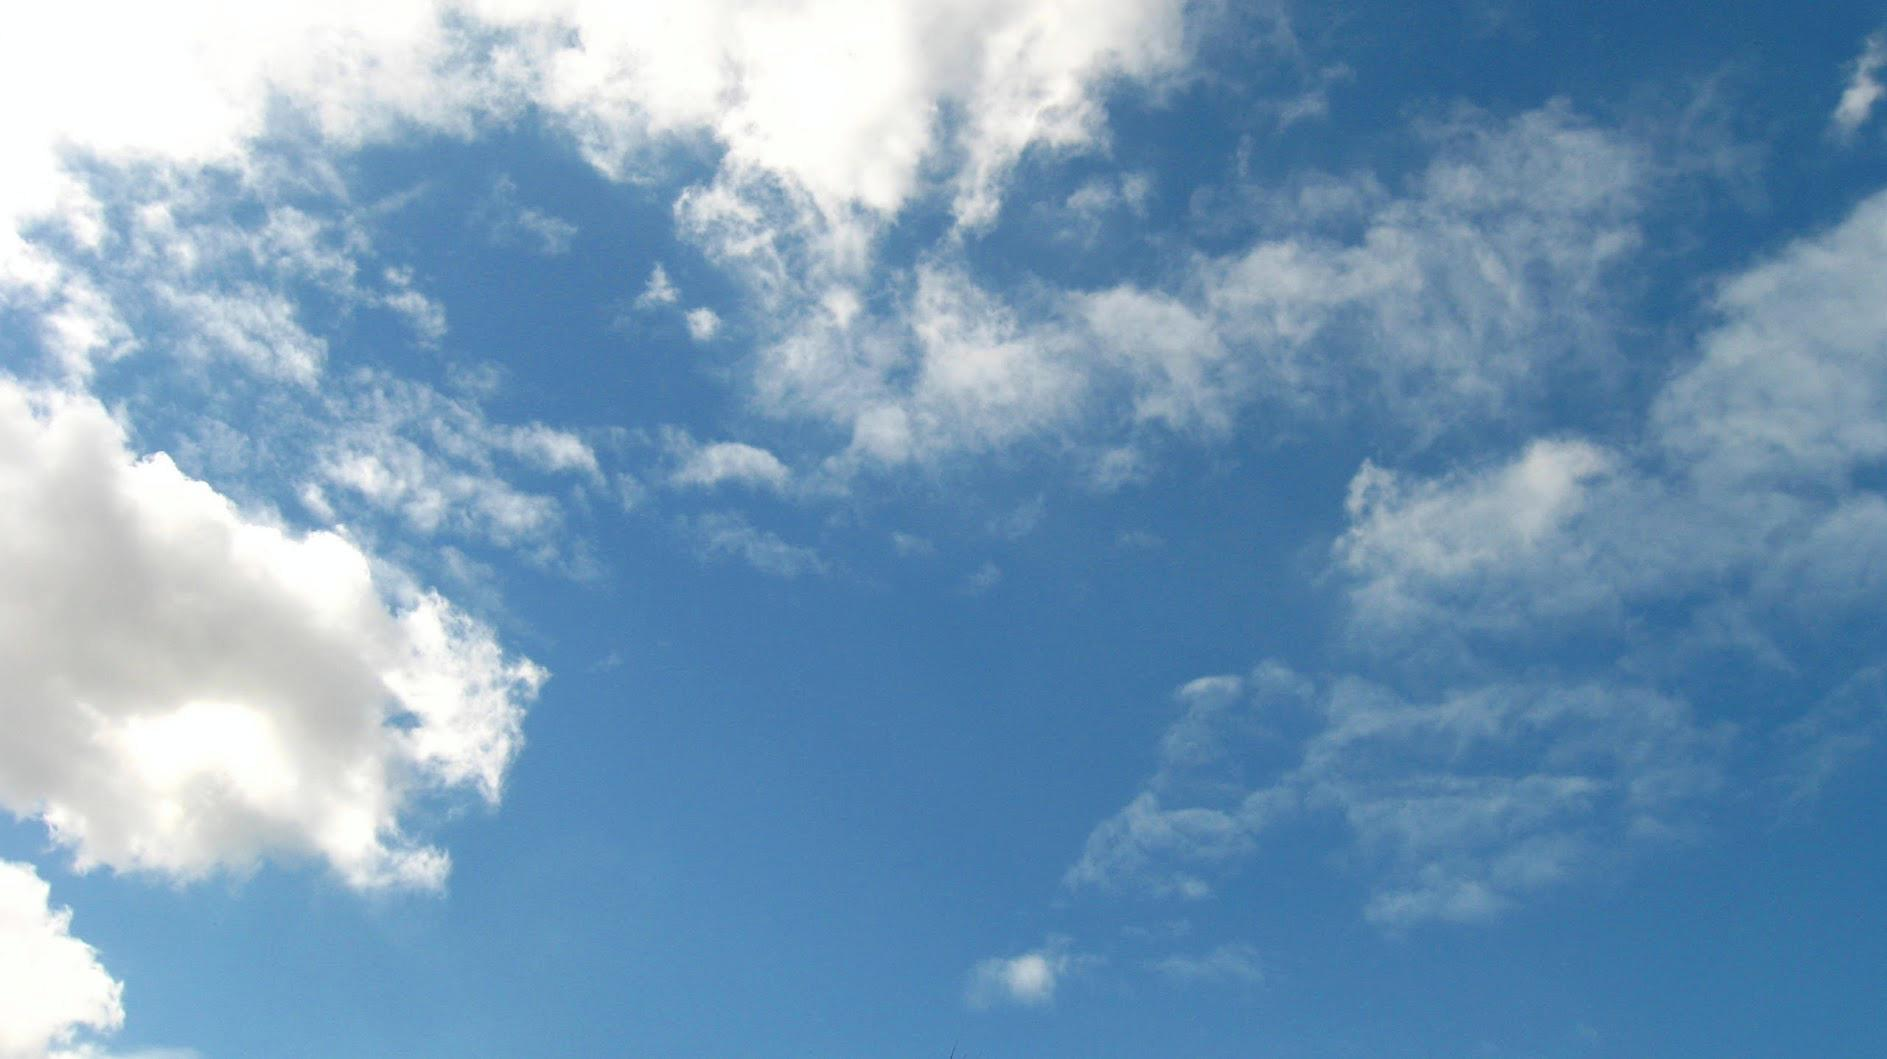

(<built-in function min>, <built-in function max>)


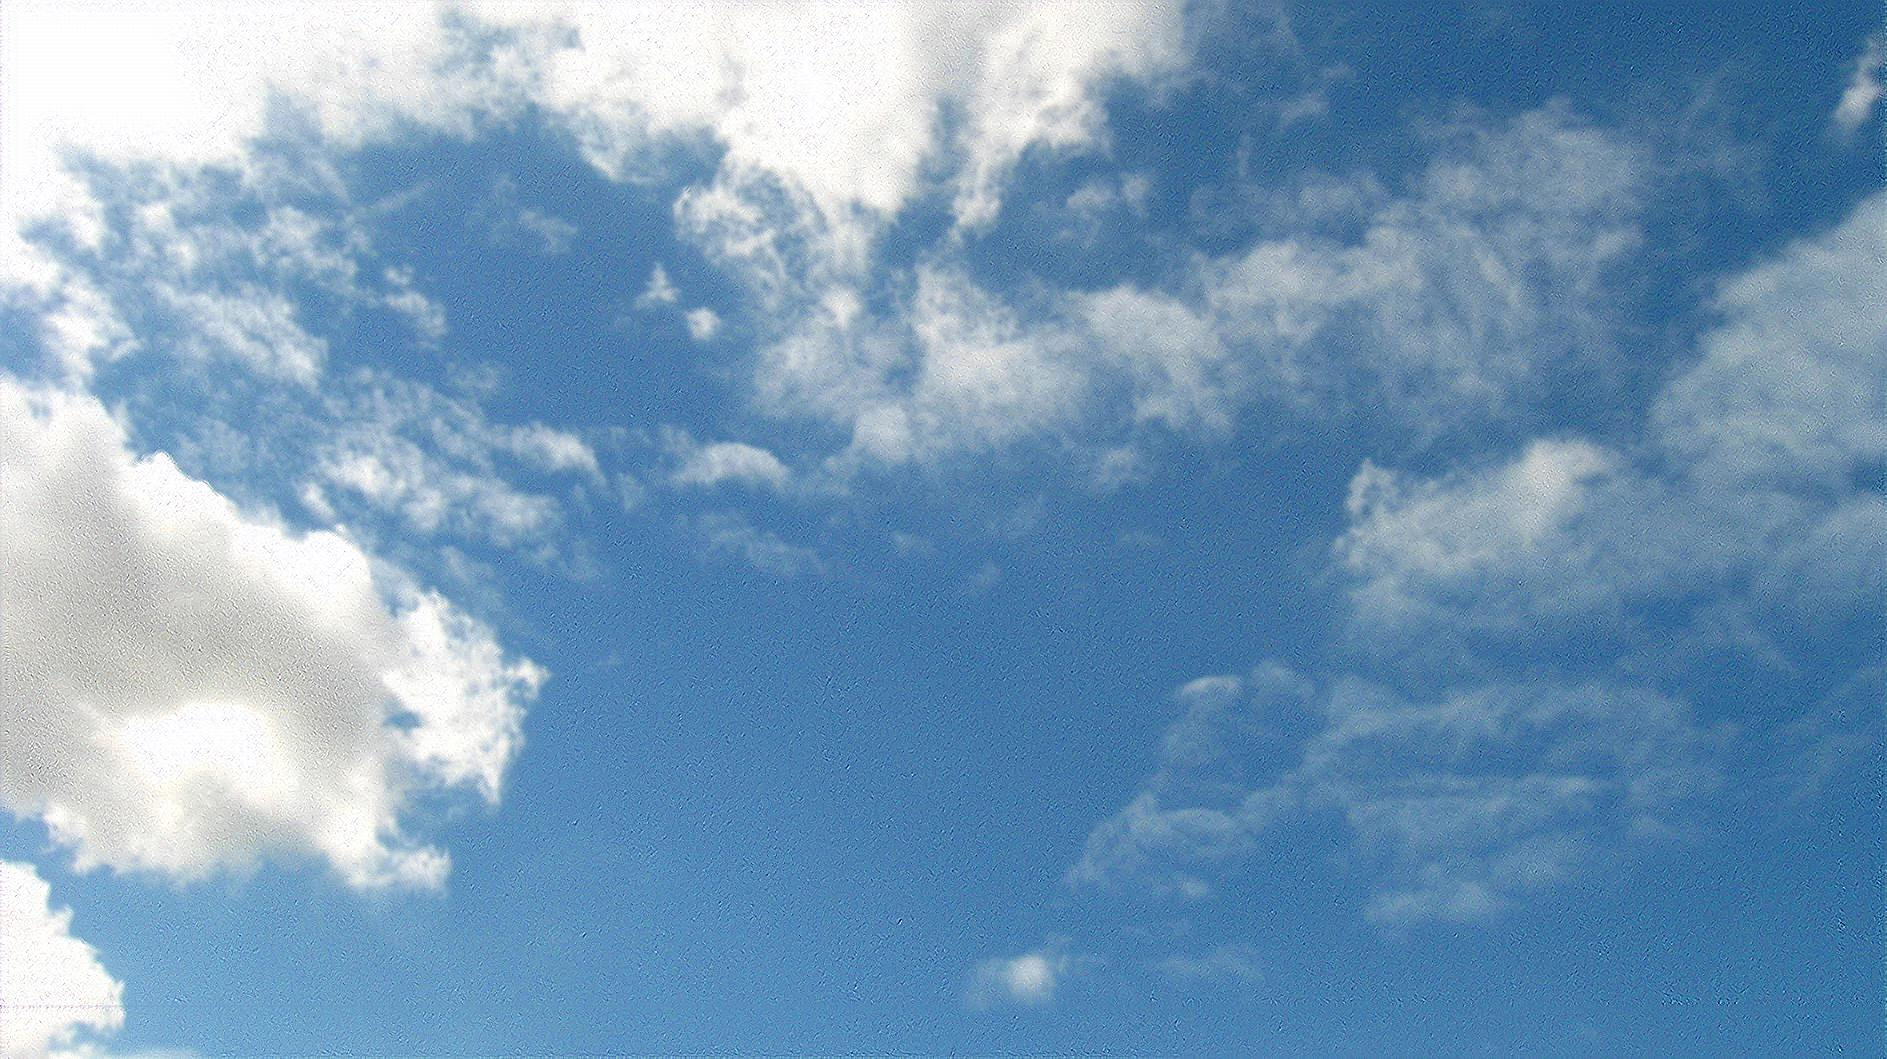

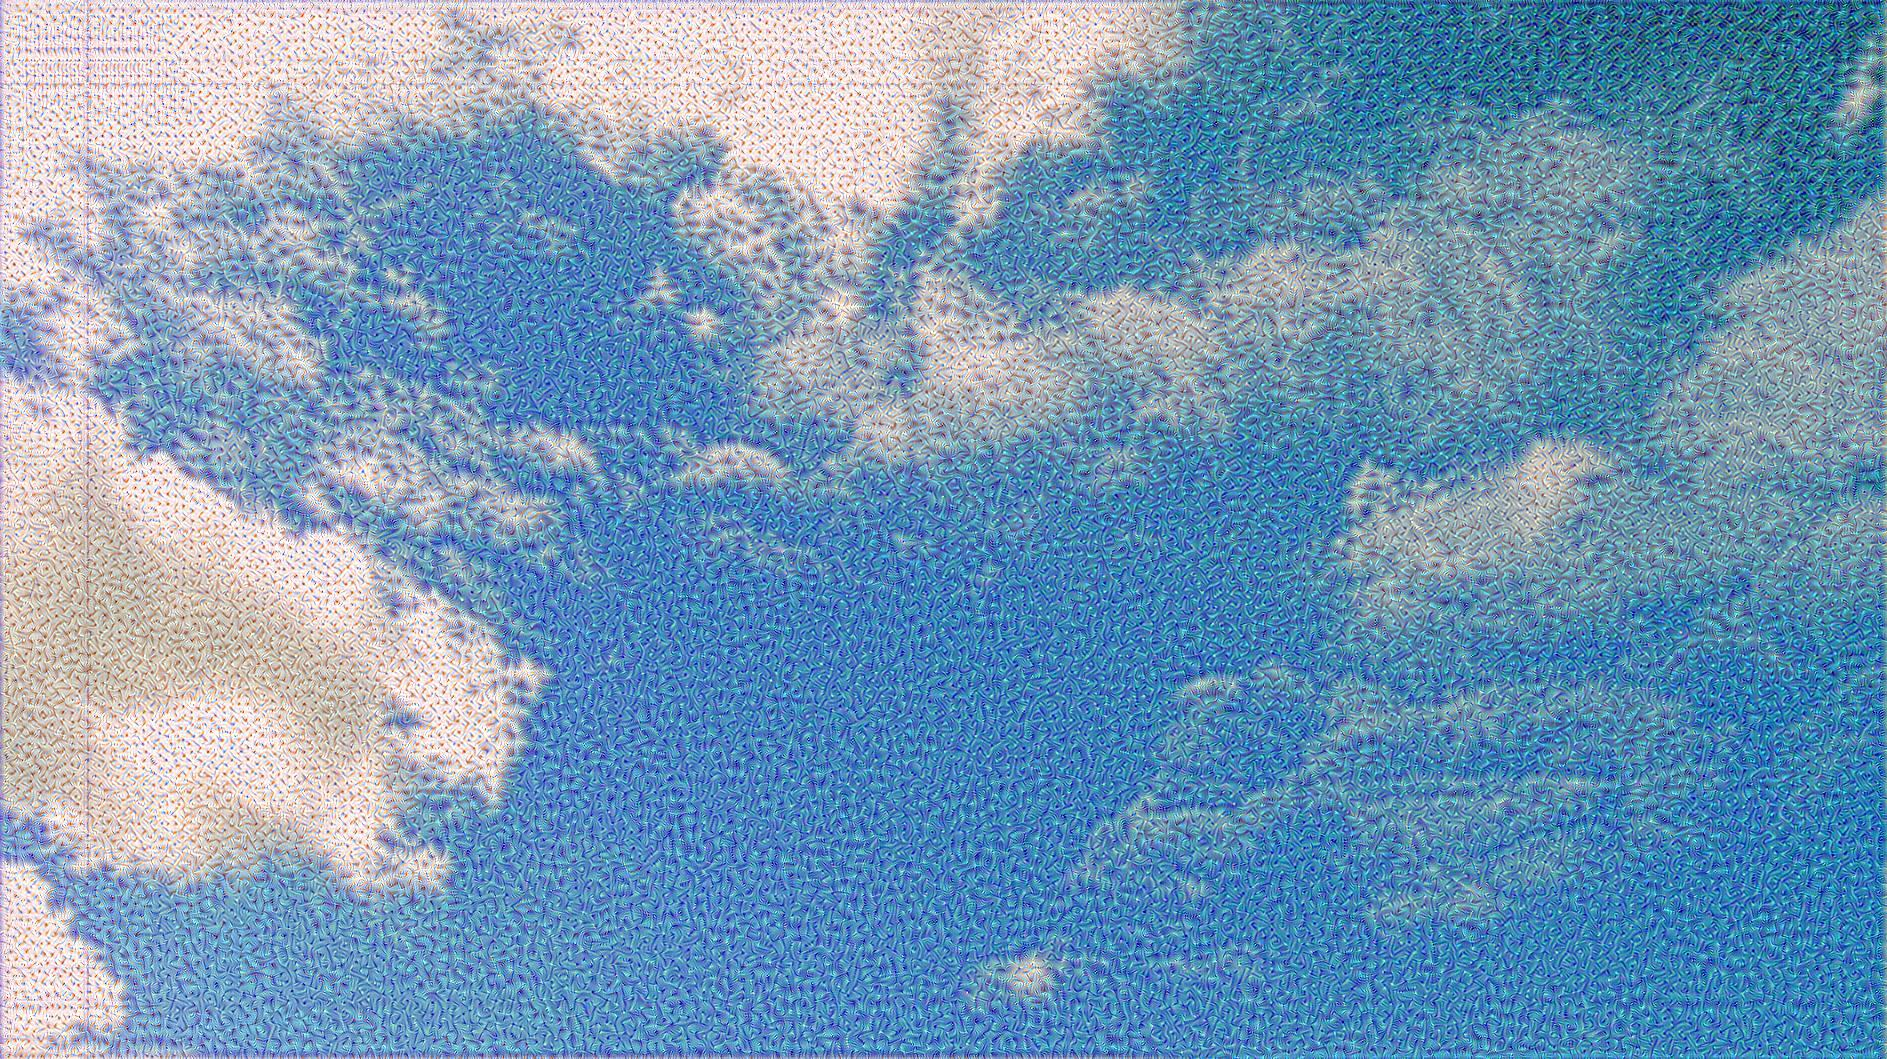

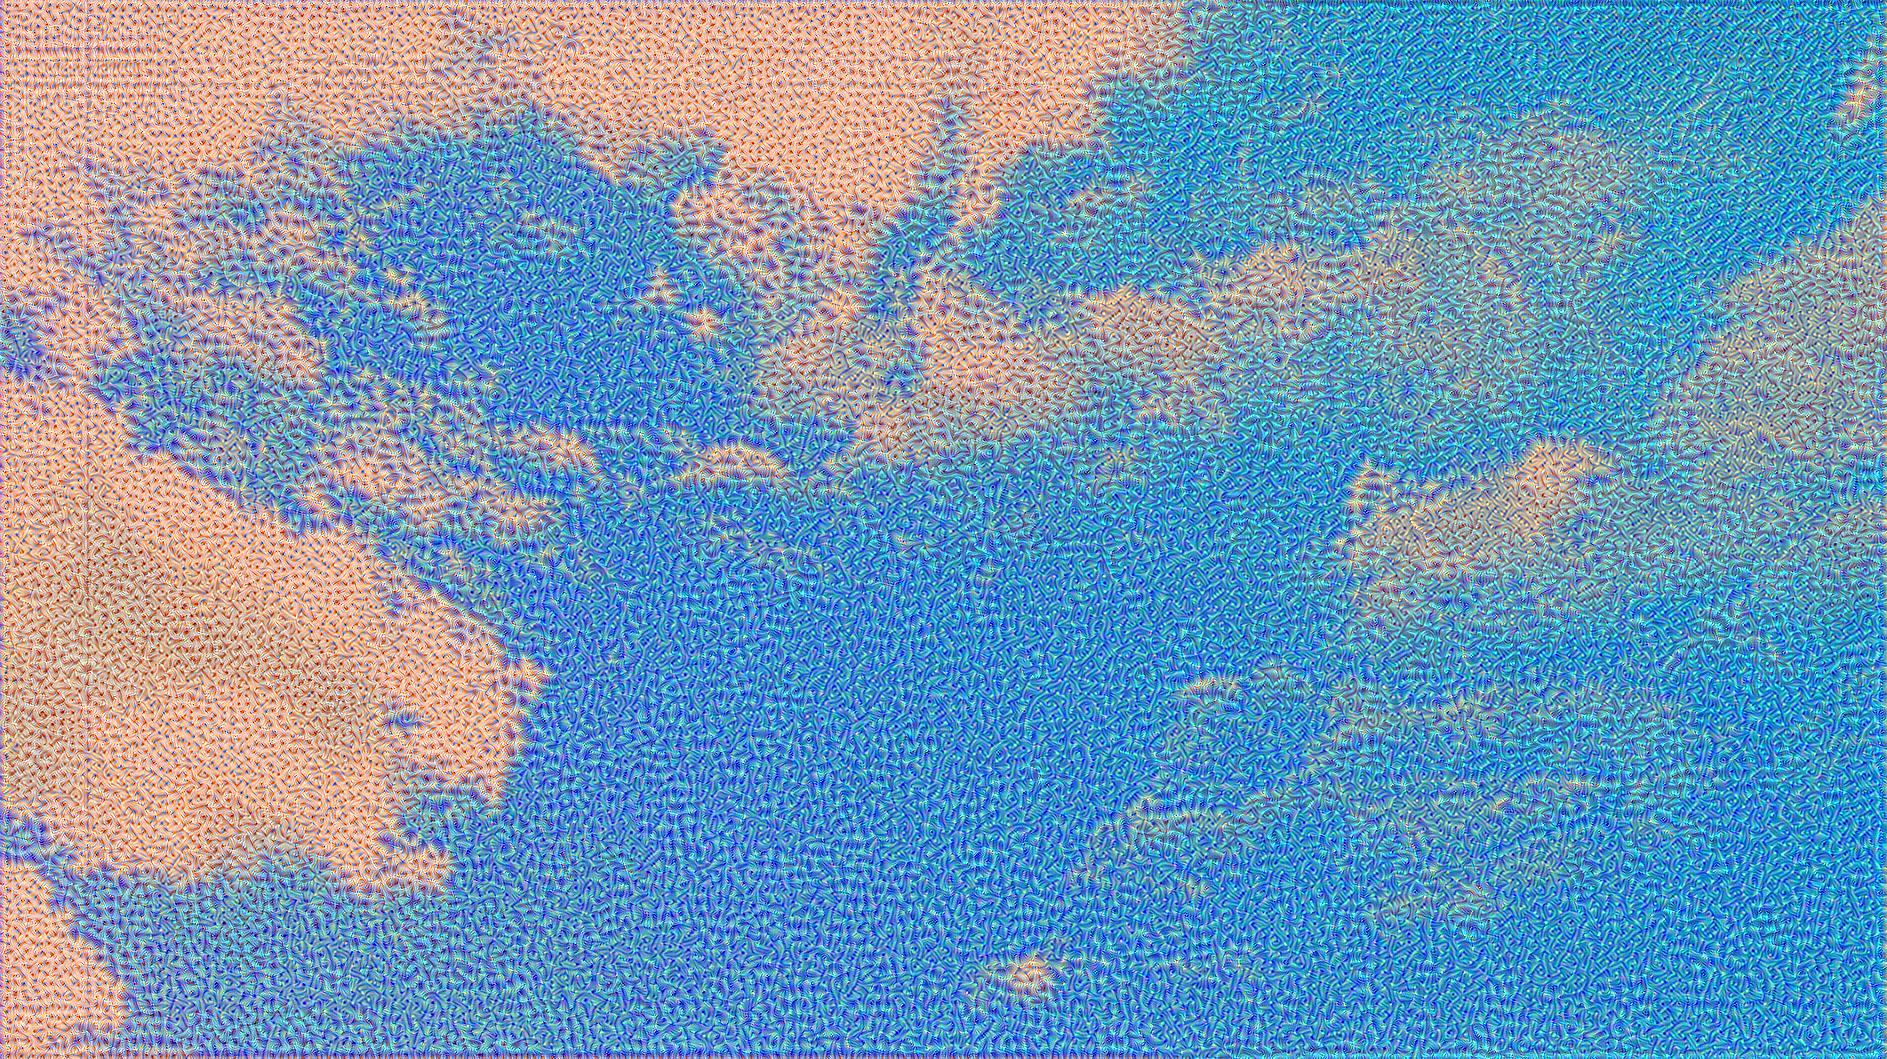

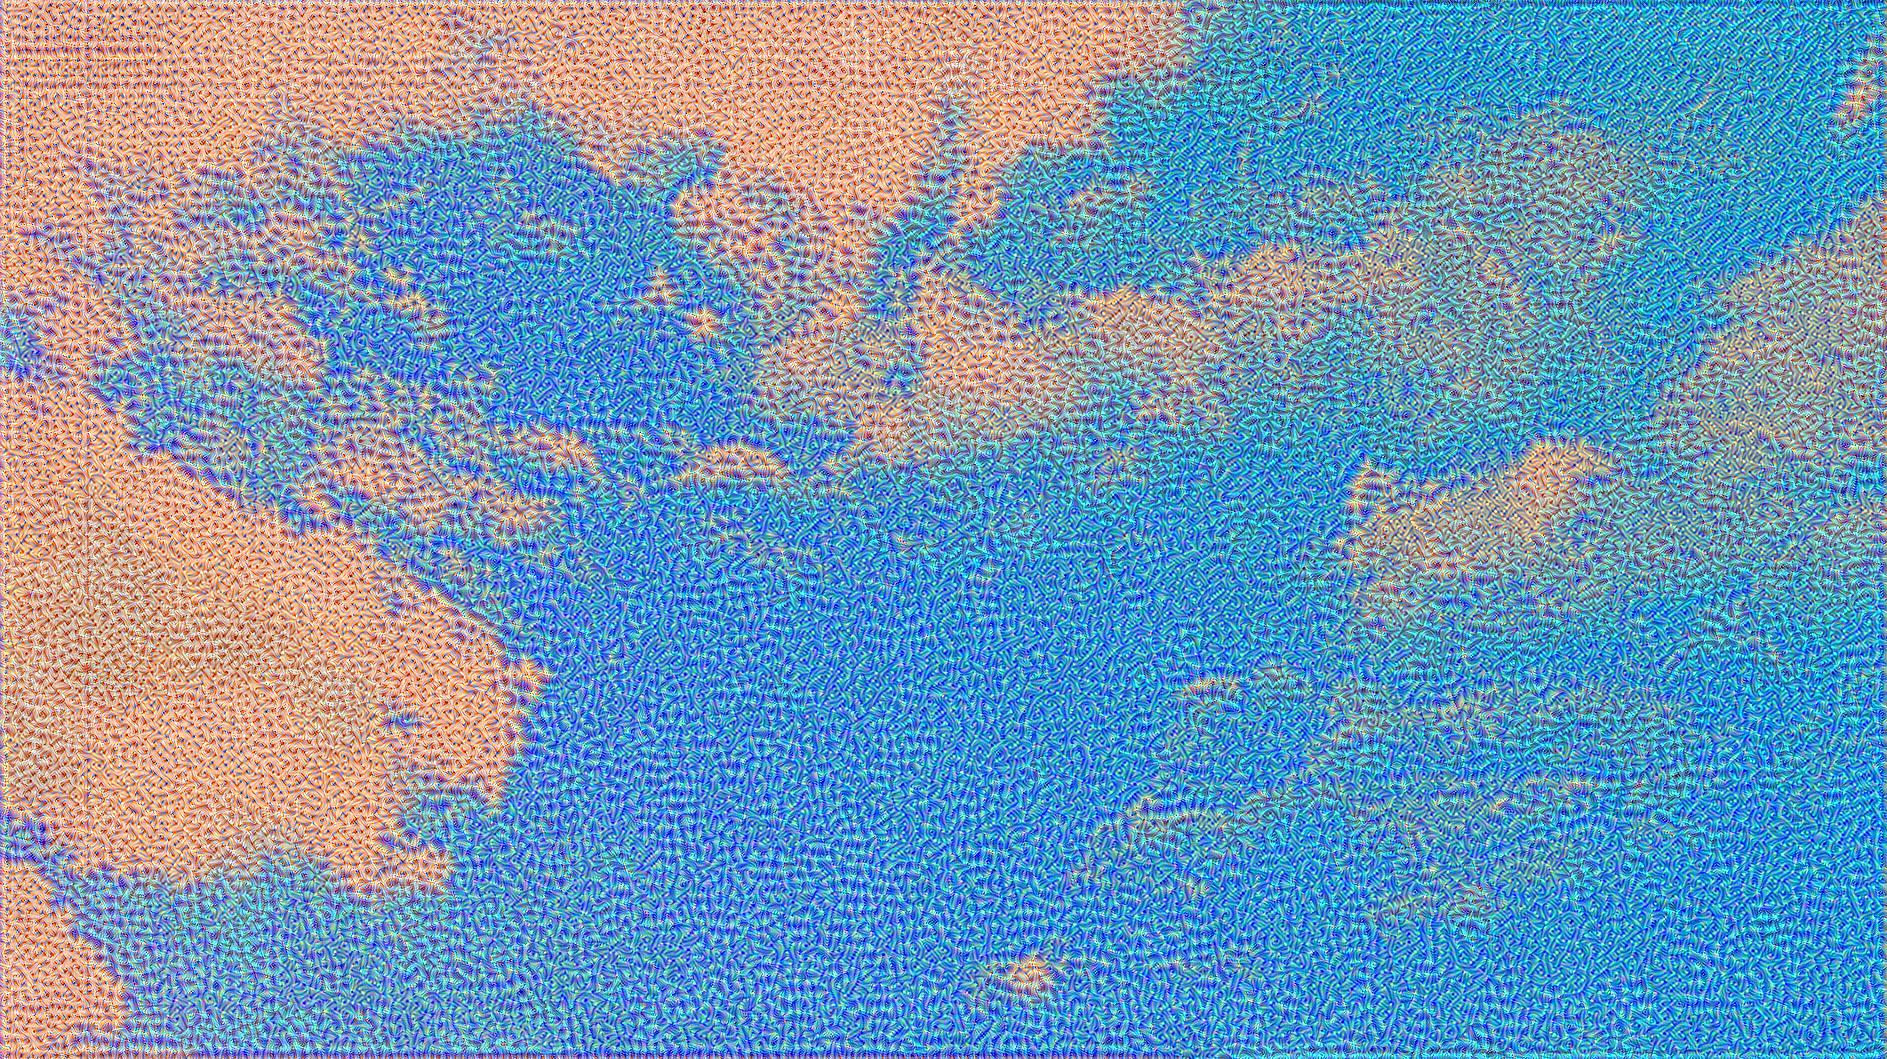

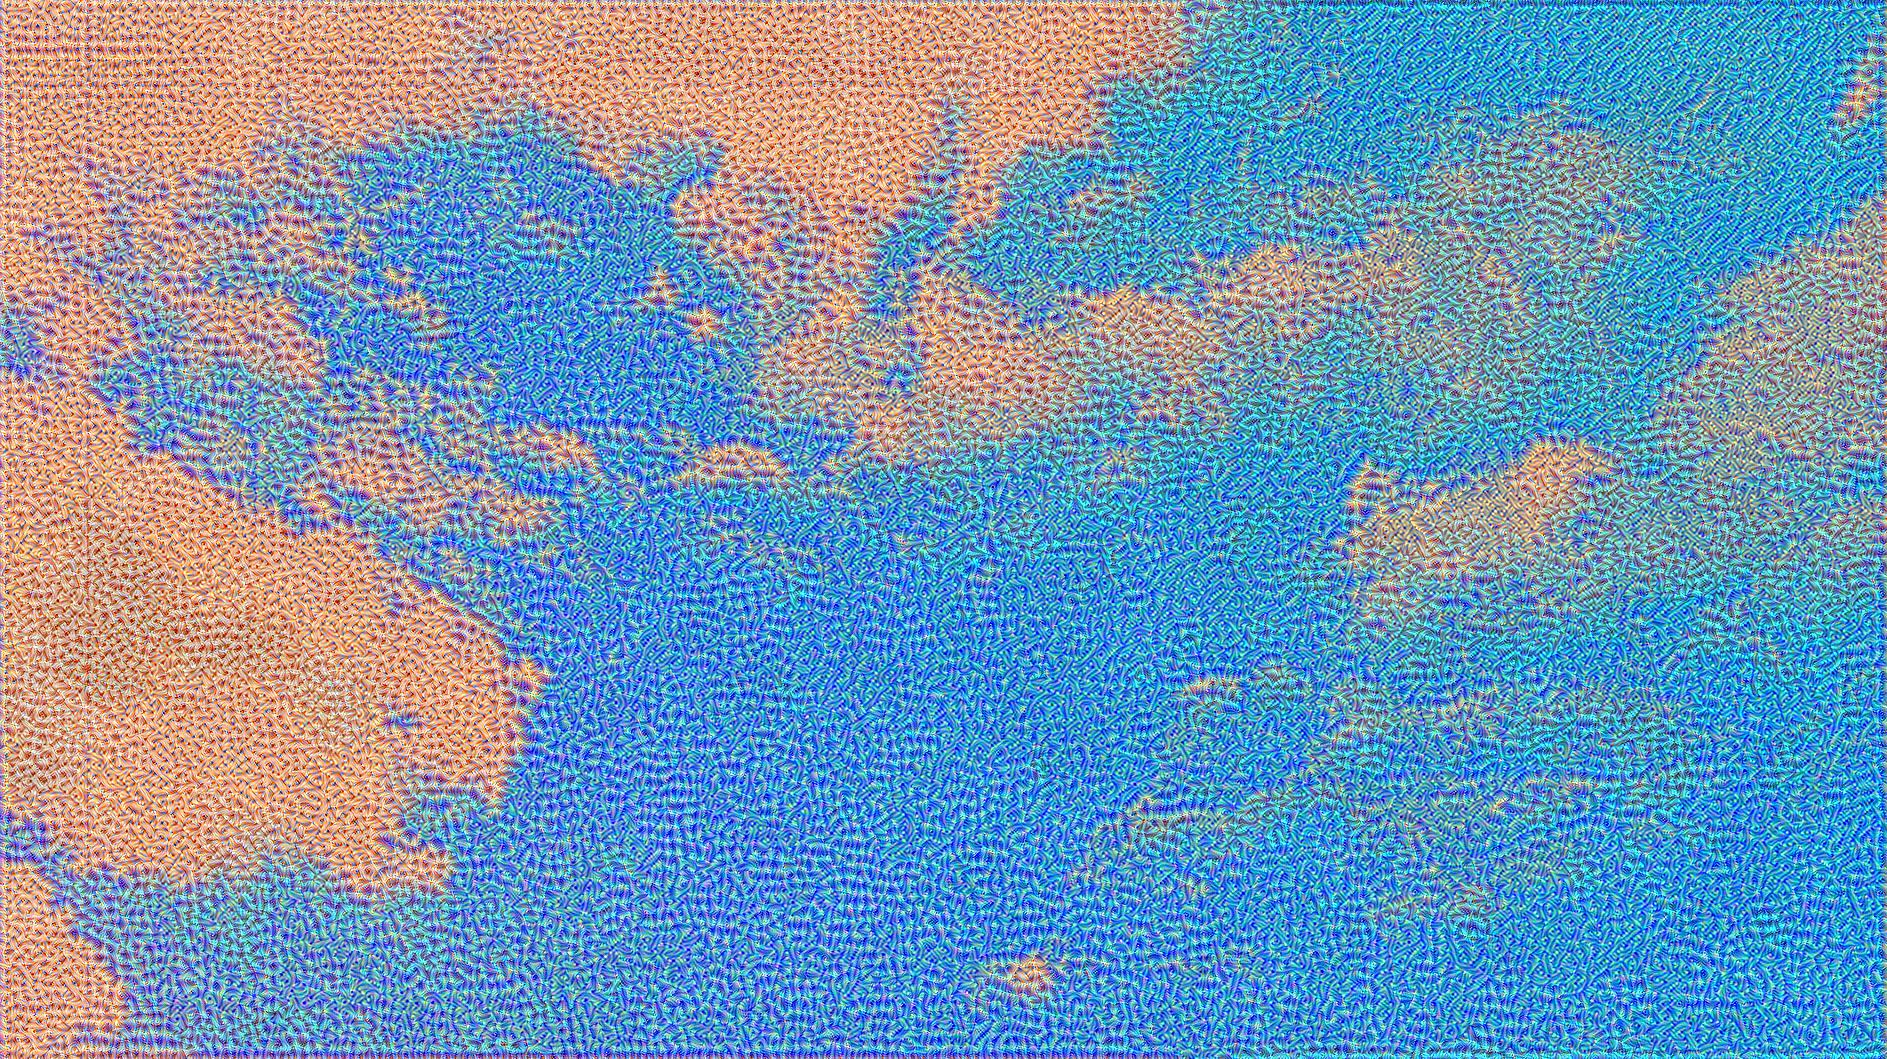

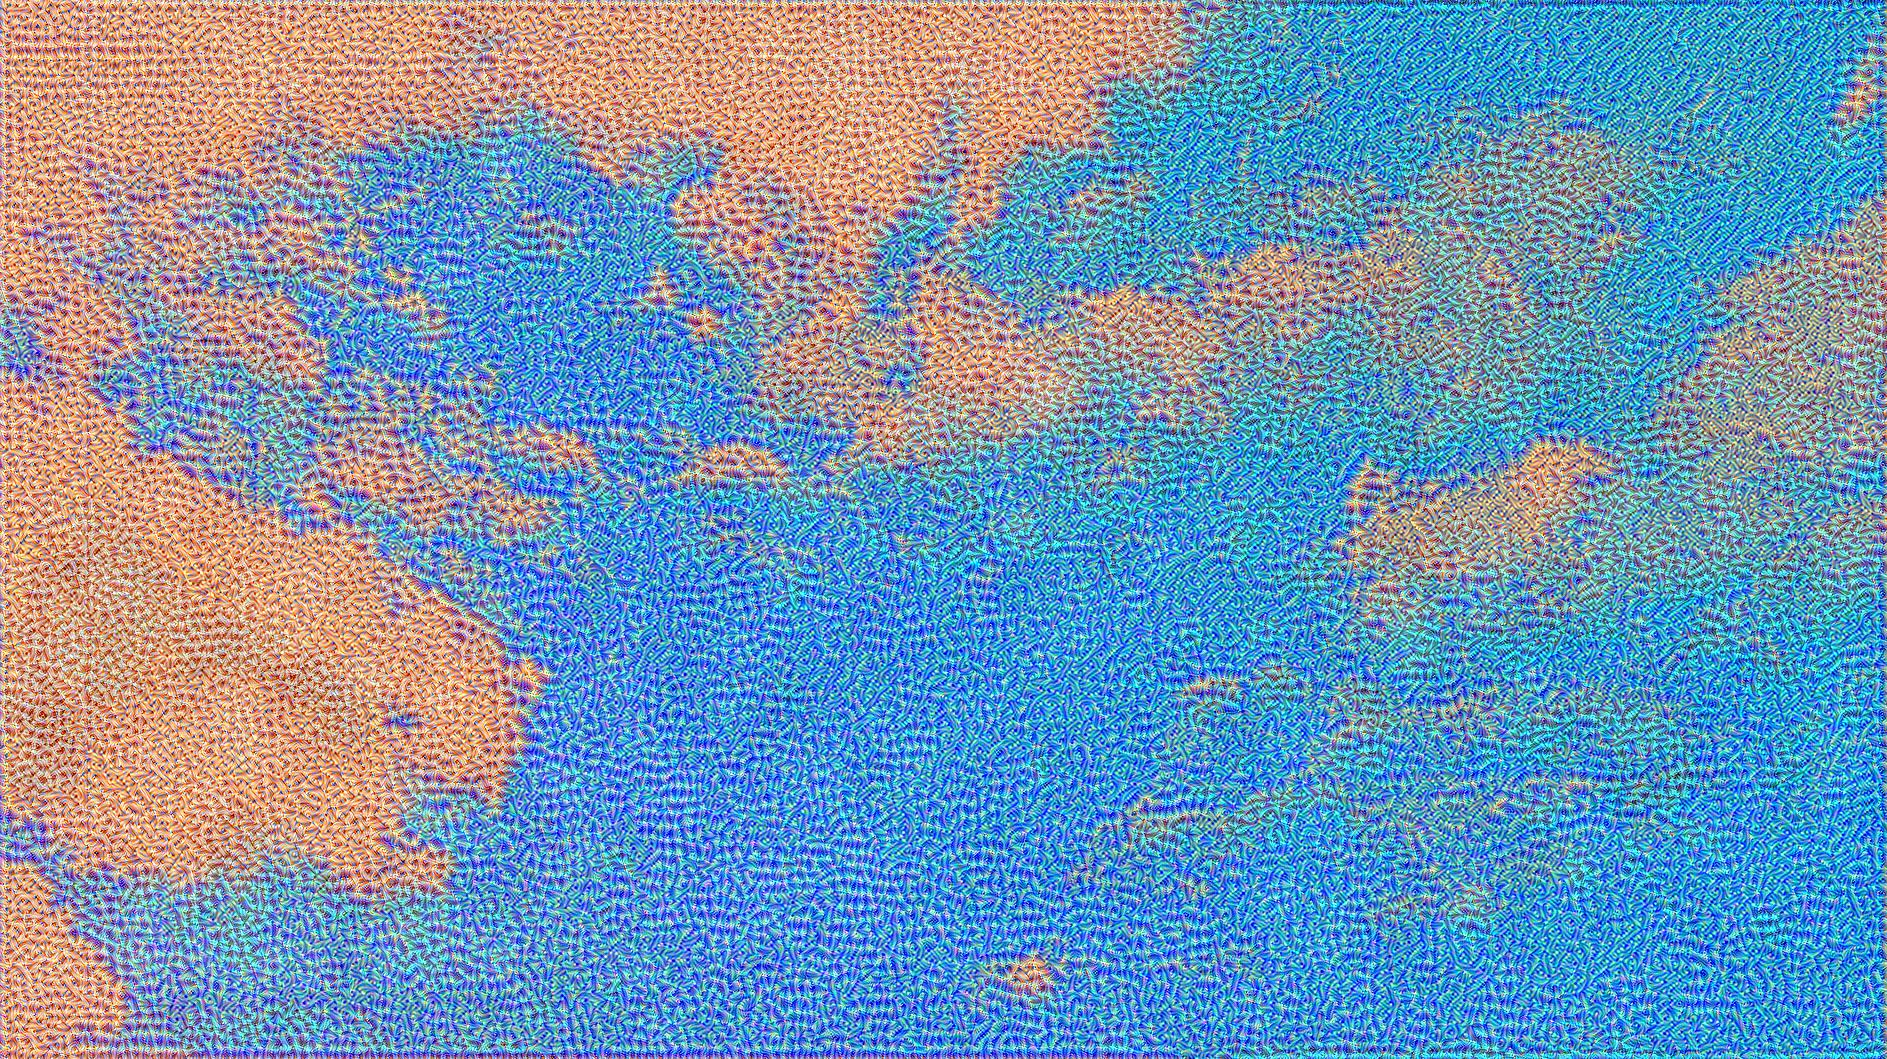

In [42]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

mean = np.array([0.485, 0.456, 0.406]).reshape([3,1,1])
std = np.array([0.229, 0.224, 0.225]).reshape([3,1,1])

model = resnet50(pretrained=True)
# model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
# model = my_resnet50(pretrained=True)
# model
# from Inception import inception_v3
# model = inception_v3(pretrained=True,)
# model = vgg16(pretrained=True)
# with torch.cuda.device(1):
model.cuda()
for param in model.parameters():
    param.requires_grad = False
# inputs.requires_grad = True
# print((input_np).shape)
inp = input_np[0,:,:,:]
inp = inp.transpose(1, 2, 0)
inp = std.reshape([1,1,3]) * inp + mean.reshape([1,1,3])
inp *= 255
showarray(inp)
out = make_step(input_np, model, lr=1e-1, num_iterations=50, show_every=10)

In [17]:
def make_step(X, model, **kwargs):
#     X = X.copy()
#   X是[1,c,w,h]的np array
    mean = np.array([0.485, 0.456, 0.406]).reshape([3,1,1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3,1,1])

    learning_rate = kwargs.pop('lr', 5.0)
    max_jitter = kwargs.pop('max_jitter', 100)
    num_iterations = kwargs.pop('num_iterations', 100)
    show_every = kwargs.pop('show_every', 25)

    print(min, max)
    for t in range(num_iterations):
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        X = np.roll(np.roll(X, ox, -1), oy, -2)

        

        model.zero_grad()
        X_tensor = torch.Tensor(X)
        X_Variable = Variable(X_tensor.cuda(), requires_grad=True)

        act_value = model(X_Variable)
#         print(act_value.size())
#         a = [0.]*1000
#         a[111] = 1.
#         a = torch.FloatTensor([a]).cuda()
#         act_value.backward(a)
        act_value.backward(act_value.data)
        
#         print('lr: {}'.format(learning_rate))
        learning_rate_ = learning_rate/np.abs(X_Variable.grad.data.cpu().numpy()).mean()
#         print(learning_rate_)
#         print(X_Variable.grad)
        X_Variable.data.add_(X_Variable.grad.data * learning_rate_)
        X = X_Variable.data.cpu().numpy()
        X = np.roll(np.roll(X, -ox, -1), -oy, -2)
        X[0,:,:,:] = np.clip(X[0,:,:,:], -mean / std, (1.-mean)/std)
#         X[0,:,:,:] = np.clip(X[0,:,:,:], -0.5, 0.6)
        if t == 0 or (t + 1) % show_every == 0:

            inp = X[0,:,:,:]
            inp = inp.transpose(1, 2, 0)
            inp = std.reshape([1,1,3]) * inp + mean.reshape([1,1,3])
            inp *= 255
            showarray(inp)
            
    return X


In [42]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

mean = np.array([0.485, 0.456, 0.406]).reshape([3,1,1])
std = np.array([0.229, 0.224, 0.225]).reshape([3,1,1])

model = resnet50(pretrained=True)
model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
# model = my_resnet50(pretrained=True)
# model
# from Inception import inception_v3
# model = inception_v3(pretrained=True,)
# model = vgg16(pretrained=True)
# with torch.cuda.device(1):
model.cuda()
for param in model.parameters():
    param.requires_grad = False
# inputs.requires_grad = True
# print((input_np).shape)
inp = input_np[0,:,:,:]
inp = inp.transpose(1, 2, 0)
inp = std.reshape([1,1,3]) * inp + mean.reshape([1,1,3])
inp *= 255
showarray(inp)
out = make_step(input_np, model, lr=1e-1, num_iterations=50, show_every=10)

TypeError: __init__() takes exactly 1 argument (3 given)

In [31]:
def deepdream(model, base_img, lr, iter_n=10, octave_n=4, octave_scale=1.4,
             end='', clip=True, **step_params):
    mean = np.array([0.485, 0.456, 0.406]).reshape([3,1,1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3,1,1])
    octaves = [base_img]
    for i in range(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0/octave_scale, 1.0/octave_scale), order=1))
    
    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0*h/h1, 1.0*w/w1), order=1)
        
        input_oct = octave_base + detail
        print(input_oct.shape)
        out = make_step(input_oct, model, lr=lr, num_iterations=iter_n, show_every=20)
        detail = out - octave_base
        print((detail.shape))
#         inp = detail[0,:,:,:]
#         inp = inp.transpose(1, 2, 0)
#         inp = std.reshape([1,1,3]) * inp + mean.reshape([1,1,3])
#         inp *= 255
#         showarray(inp)
        

(1, 3, 197, 351)
(<built-in function min>, <built-in function max>)


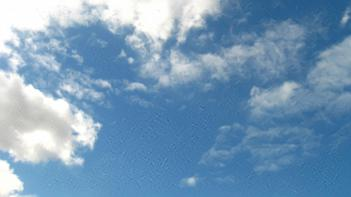

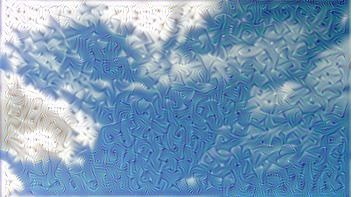

(1, 3, 197, 351)
(1, 3, 276, 491)
(<built-in function min>, <built-in function max>)


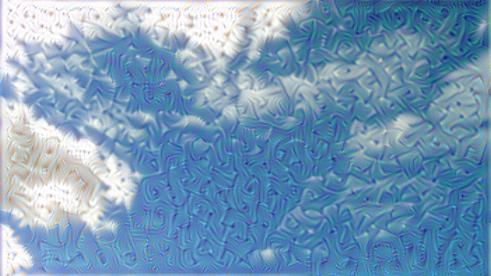

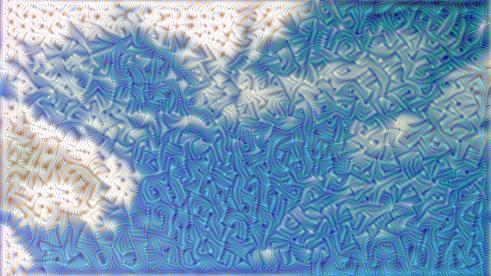

(1, 3, 276, 491)
(1, 3, 386, 688)
(<built-in function min>, <built-in function max>)


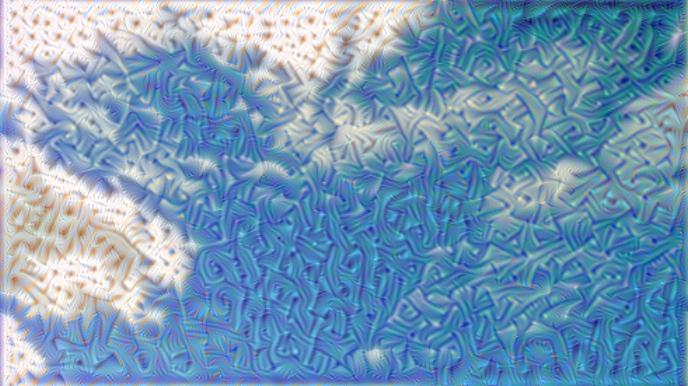

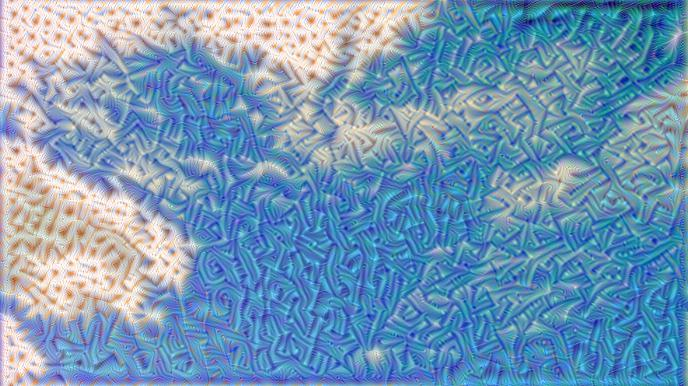

(1, 3, 386, 688)
(1, 3, 540, 963)
(<built-in function min>, <built-in function max>)


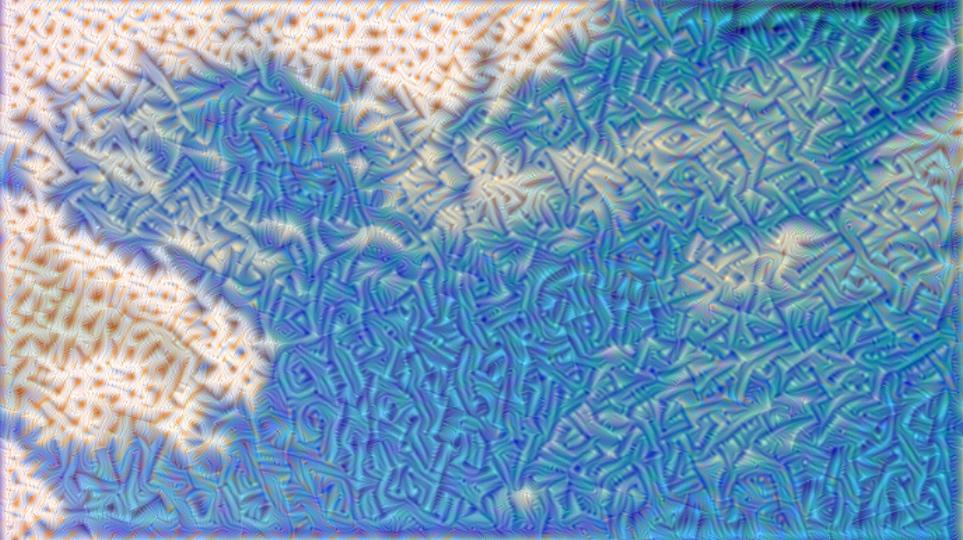

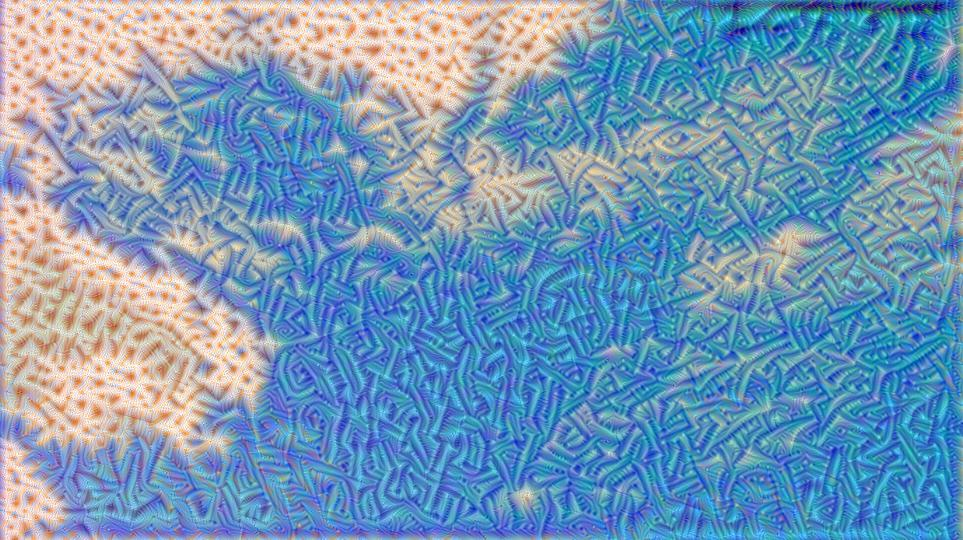

(1, 3, 540, 963)
(1, 3, 756, 1348)
(<built-in function min>, <built-in function max>)


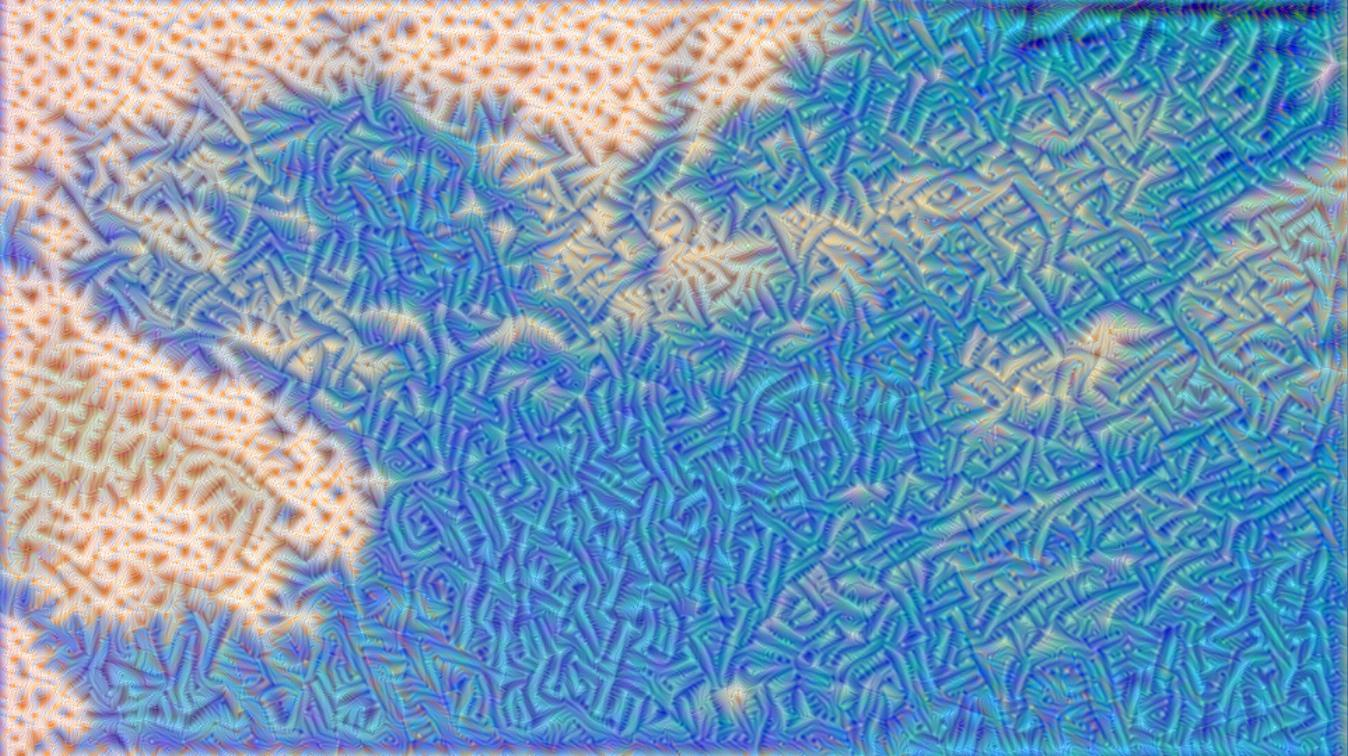

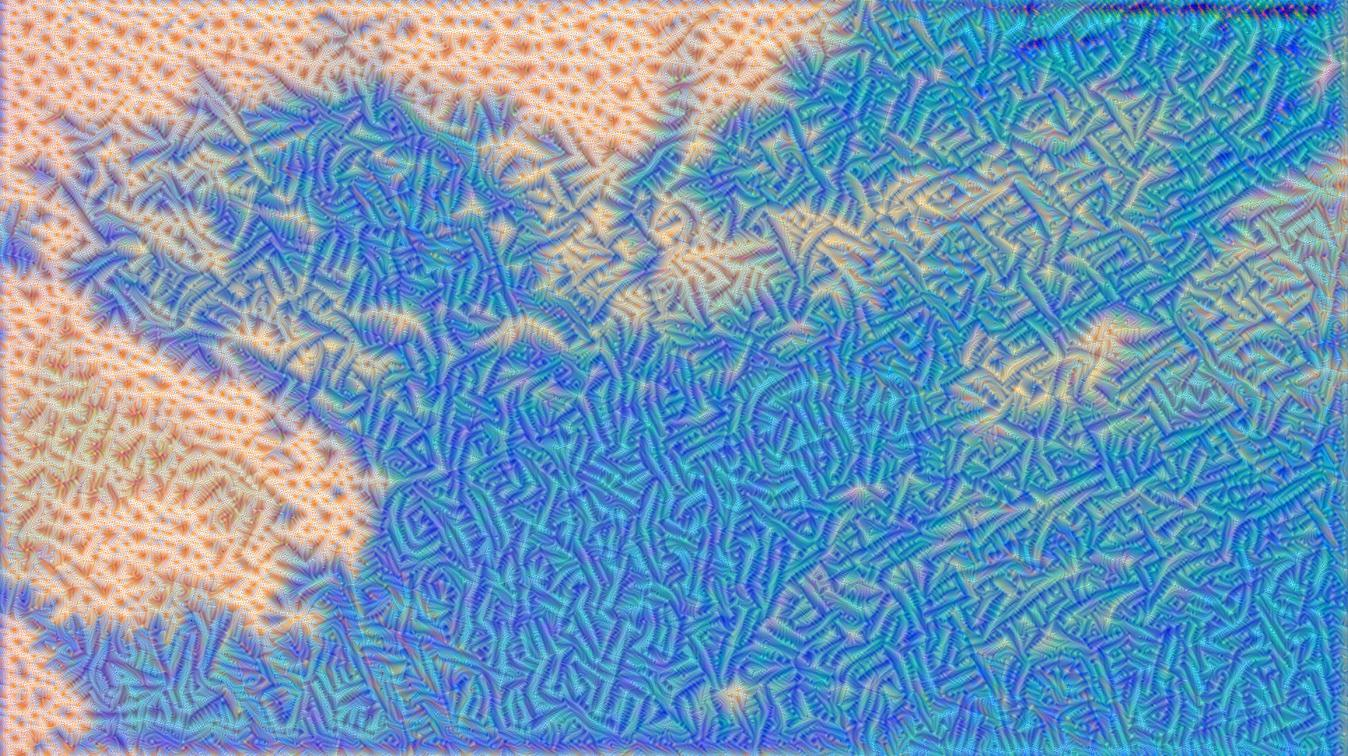

(1, 3, 756, 1348)
(1, 3, 1059, 1887)
(<built-in function min>, <built-in function max>)


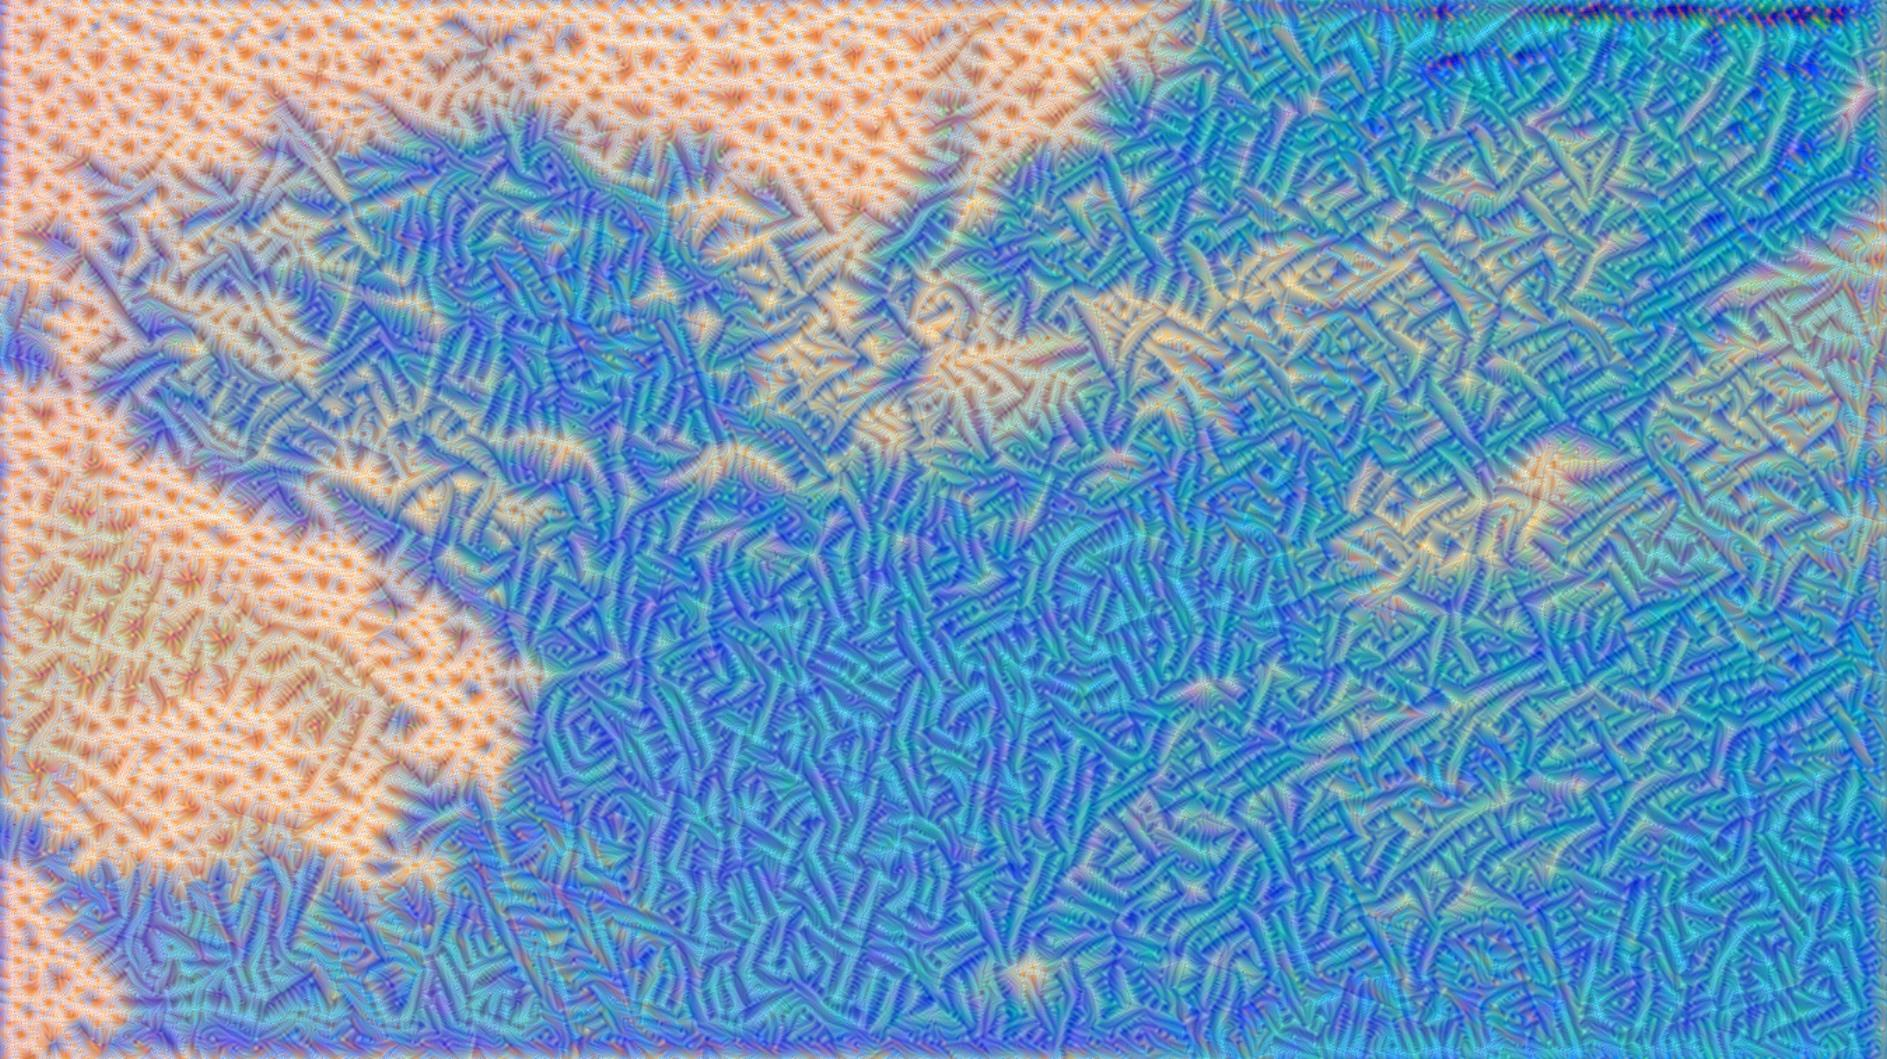

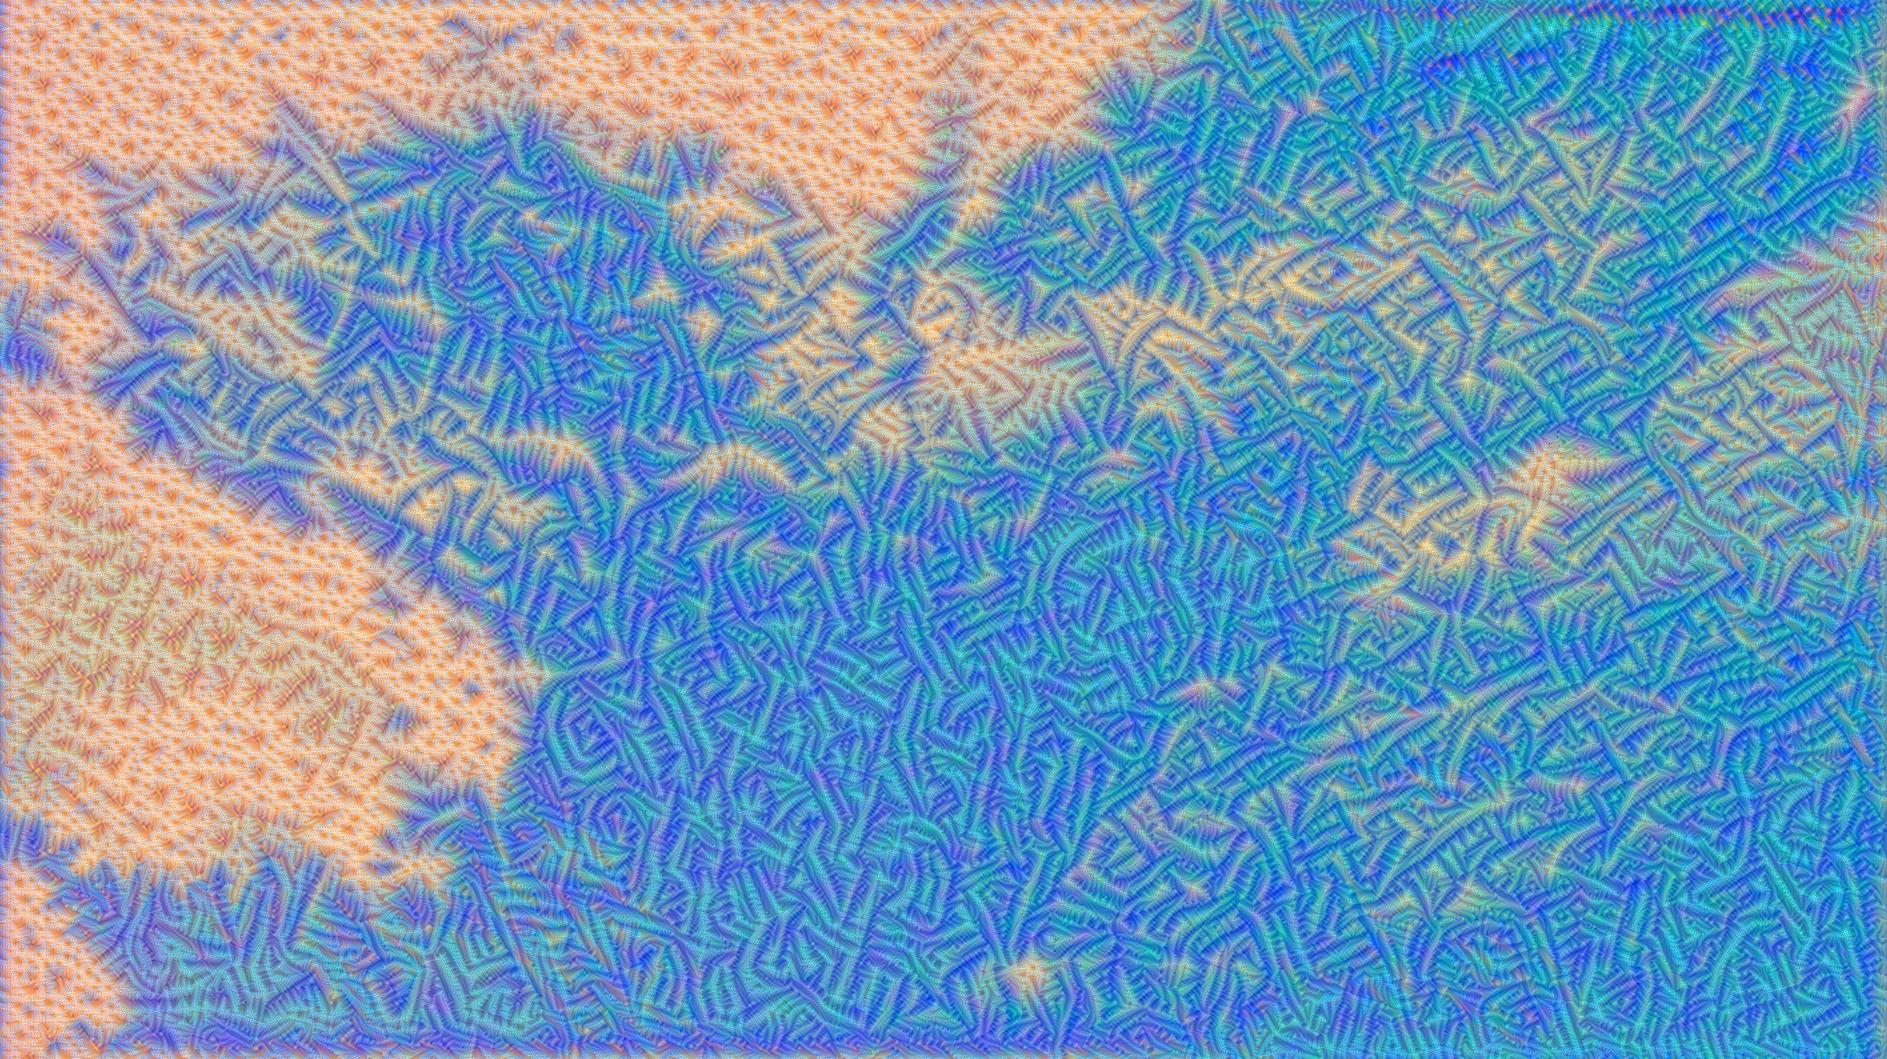

(1, 3, 1059, 1887)


In [43]:
deepdream(model, input_np, octave_n=6, iter_n=20, lr=2e-2)